Loading data from datasets

In [1]:
import pandas as pd

data_train = pd.read_csv("sample_data/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("sample_data/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("sample_data/test.tsv", sep="\t", header=None)

In [2]:
#Viewing sample train data before preprocessing
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
#Viewing sample train data counts
data_train.shape

(10240, 14)

In [4]:
#Viewing count of data in seprate of labels
# Filter the DataFrame based on the label
filtered_data1 = data_train[data_train.iloc[:, 1] ==  'false']
filtered_data2 = data_train[data_train.iloc[:, 1]  == "pants-fire"]
filtered_data3 = data_train[data_train.iloc[:, 1]  == "true"]
filtered_data4 = data_train[data_train.iloc[:, 1]  == "mostly-true"]
filtered_data5 = data_train[data_train.iloc[:, 1]  == "half-true"]
filtered_data6 = data_train[data_train.iloc[:, 1]  == "barely-true"]
# Display the result
print(f"The number of rows with label false is: {filtered_data1.shape[0]}")
print(f"The number of rows with label pants-fire is: {filtered_data2.shape[0]}")
print(f"The number of rows with label true is: {filtered_data3.shape[0]}")
print(f"The number of rows with label mostly-true is: {filtered_data4.shape[0]}")
print(f"The number of rows with label half-true is: {filtered_data5.shape[0]}")
print(f"The number of rows with label barely-true is: {filtered_data6.shape[0]}")

The number of rows with label false is: 1995
The number of rows with label pants-fire is: 839
The number of rows with label true is: 1676
The number of rows with label mostly-true is: 1962
The number of rows with label half-true is: 2114
The number of rows with label barely-true is: 1654


convert 6 classes to 2 classes

In [5]:
def combine_classes(dataset):
    #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
    dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]]
    
    #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
    meta = []
    for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
    #Adding cleaned and combined metadata column to the dataset
    dataset[14] = meta
    dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

    #Dropping unwanted columns
    dataset = dataset.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] ,axis=1)
    dataset.dropna() #Dropping if there are still any null values
    return dataset

In [6]:
#Applying reduce_classes to the raw data - train, valid and test sets
data_train = combine_classes(data_train)
data_valid = combine_classes(data_valid)
data_test = combine_classes(data_test)
data_train.head(3)


,label,sentence
0,0,abortion dwayne-bohac State representative Tex...
1,0,"energy,history,job-accomplishments scott-surov..."
2,1,foreign-policy barack-obama President Illinois...


In [7]:
#Viewing count of data in seprate of labels
data_train['label'].value_counts(normalize='true')

0    0.644727
1    0.355273
Name: label, dtype: float64

Preproccesing

In [8]:
#importing required packages  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def data_preprocessing(dataset):
    preprocessed_texts = []
    for text in dataset:
        # convert to lowercase
        text = text.lower()    
        # tokenize text
        tokens = word_tokenize(text)
        # remove punctuation and irrelevant characters
        filtered_tokens = [token for token in tokens if token.isalnum()]
        # remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in filtered_tokens if not token in stop_words]
        # lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        # stem tokens
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
        # join tokens back into string
        preprocessed_text = ' '.join(filtered_tokens)
        preprocessed_texts.append(preprocessed_text)
    return preprocessed_texts

In [9]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train['sentence'] = data_preprocessing(data_train['sentence'])
data_valid['sentence'] = data_preprocessing(data_valid['sentence'])
data_test['sentence'] = data_preprocessing(data_test['sentence'])
#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,abort state repres texa republican mailer say ...
1,0,energi histori state deleg virginia democrat f...
2,1,presid illinoi democrat denver hillari clinton...
3,0,nan nan none news releas health care reform le...
4,0,economi job nan florida democrat interview cnn...


Feature engineering

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def feature_engineering(dataset):
    preprocessed_texts = dataset['sentence']   
    tfidf_vect = TfidfVectorizer(ngram_range=(2, 2), max_features=150)
    tfidf_matrix = tfidf_vect.fit_transform(preprocessed_texts)
    tfidf_matrix.sort_indices()
    vocab_size = len(tfidf_vect.vocabulary_)
    return tfidf_matrix

In [24]:
from sklearn.decomposition import TruncatedSVD

def reduce_dimension_SVD(data_matrix):
    svd_model = TruncatedSVD(n_components=200)
    svd_matrix = svd_model.fit_transform(data_matrix)
    return svd_matrix

In [25]:
#Applying feature_engineering to the preproccessed data - train, valid and test sets
X_features_train = feature_engineering(data_train)
X_features_valid = feature_engineering(data_valid)
X_features_test = feature_engineering(data_test)

# X_features_train = reduce_dimension_SVD(X_features_train)
# X_features_valid = reduce_dimension_SVD(X_features_valid)
# X_features_test = reduce_dimension_SVD(X_features_test)
print(X_features_train.shape[1])


150


Ensemble Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def create_ensemble_models(X_train, y_train,X_val, y_val):
    num_models = 3
    models = []
    for i in range(num_models):
        model = Sequential()
        model.add(Embedding(vocab_size, 100, input_length=max_len))
        model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, name=f'lstm_layer_{i}'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

        models.append(model)
        
    return models

In [27]:
import numpy as np

def predict_ensemble_models(X_valid, X_test, y_valid, y_test, models):
    # Make predictions on the validation set
    y_pred_ensemble_valid = np.zeros_like(y_valid, dtype = np.float64)
    for model in models:
        y_pred_valid = model.predict(X_valid)
        y_pred_ensemble_valid += np.squeeze((y_pred_valid > 0.5).astype(int))

    y_pred_ensemble_valid /= len(models)
    y_pred_ensemble_valid = np.round(y_pred_ensemble_valid).astype(int)

    # Make predictions on the test set
    y_pred_ensemble = np.zeros_like(y_test, dtype=np.float64)
    for model in models:
        y_pred = model.predict(X_test)
        y_pred_ensemble += np.squeeze((y_pred > 0.5).astype(int))

    y_pred_ensemble /= 3
    y_pred_ensemble = np.round(y_pred_ensemble).astype(int)

    return y_pred_ensemble_valid, y_pred_ensemble

In [29]:
#part 1
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess the data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data_train['sentence'])
# vocab_size = len(tokenizer.word_index) + 1

# X_train = tokenizer.texts_to_sequences(data_train['sentence'])
# X_valid = tokenizer.texts_to_sequences(data_valid['sentence'])
# X_test = tokenizer.texts_to_sequences(data_test['sentence'])
vocab_size = 150
X_train = X_features_train
X_valid = X_features_valid
X_test = X_features_test

# max_len = 150  # Define the maximum sequence length
# X_train = pad_sequences(X_features_train, maxlen=max_len)
# X_valid = pad_sequences(X_features_valid, maxlen=max_len)
# X_test = pad_sequences(X_features_test, maxlen=max_len)

y_train = np.array(data_train['label'])  # Convert to numpy array
y_valid = np.array(data_valid['label'])  # Convert to numpy array
y_test = np.array(data_test['label'])  # Convert to numpy array

In [30]:
#Part2 : Create ensemble model
models = create_ensemble_models(X_train, y_train,X_valid, y_valid)

Epoch 1/5
160/160 [==============================] - 77s 468ms/step - loss: 0.6527 - accuracy: 0.6424 - val_loss: 0.6382 - val_accuracy: 0.6729
Epoch 2/5
160/160 [==============================] - 89s 553ms/step - loss: 0.6513 - accuracy: 0.6447 - val_loss: 0.6345 - val_accuracy: 0.6729
Epoch 3/5
160/160 [==============================] - 91s 572ms/step - loss: 0.6514 - accuracy: 0.6447 - val_loss: 0.6326 - val_accuracy: 0.6729
Epoch 4/5
160/160 [==============================] - 91s 571ms/step - loss: 0.6512 - accuracy: 0.6447 - val_loss: 0.6354 - val_accuracy: 0.6729
Epoch 5/5
160/160 [==============================] - 95s 593ms/step - loss: 0.6512 - accuracy: 0.6447 - val_loss: 0.6345 - val_accuracy: 0.6729
Epoch 1/5
160/160 [==============================] - 90s 547ms/step - loss: 0.6525 - accuracy: 0.6434 - val_loss: 0.6336 - val_accuracy: 0.6729
Epoch 2/5
160/160 [==============================] - 99s 617ms/step - loss: 0.6514 - accuracy: 0.6447 - val_loss: 0.6326 - val_accuracy:

In [29]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [31]:
from keras.utils.vis_utils import plot_model

#Visualizing
plot_model(models[0], show_shapes=True, to_file='model-arch.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
y_pred_ensemble_valid, y_pred_ensemble = predict_ensemble_models(X_valid, X_test, y_valid, y_test, models)

40/40 [==============================] - 1s 36ms/step


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

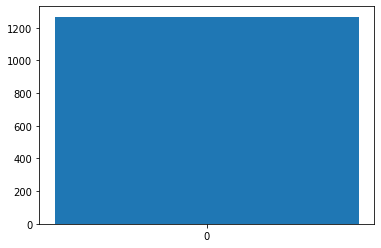

In [40]:
import matplotlib.pyplot as plt

#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
# Create a bar plot
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']

# Set the x-axis tick labels to the class labels
plt.xticks(range(len(class_counts)), class_labels)

# Set the plot title and axes labels
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')

# Display the plot
plt.show()

In [33]:
from sklearn.metrics import f1_score, classification_report

# Print classification report
f_score = f1_score(data_test['label'], y_pred_ensemble, average='micro')
print("Model2 - Ensemble F1-score:", f_score)
print("Model2 - Classification Report:")
print(classification_report(data_test['label'], y_pred_ensemble))

Model2 - Ensemble F1-score: 0.6456195737963694
Model2 - Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.00      0.00      0.00       449

    accuracy                           0.65      1267
   macro avg       0.32      0.50      0.39      1267
weighted avg       0.42      0.65      0.51      1267



c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

MLP Classifier

In [38]:
from sklearn.neural_network import MLPClassifier

def build_mlp():
    # Step 1: increase the training data with ensemble predictions
    X_train_increased = np.concatenate((X_valid, y_pred_ensemble_valid[:X_valid.getnnz()].reshape(-1, 1)), axis=1)

    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(X_train_increased, y_valid)

    X_test_increased = np.concatenate((X_test, y_pred_ensemble[:X_test.getnnz()].reshape(-1, 1)), axis=1)
    #X_test_increased = np.concatenate([X_test] + reshaped_weights + [y_pred_ensemble[:len(X_test)].reshape(-1, 1)], axis=1)

    mlp_predictions = mlp_classifier.predict(X_test_increased)
    return mlp_predictions

In [39]:
mlp_predictions = build_mlp()

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate F-score and accuracy
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))

print("Model2 - MLP F-score:", f_score)
print("Model2 - MLP Accuracy:", accuracy)